# Human lymph node dataset

We analyzed the human lymph node dataset. Human Lymph Node can be obtained from 10x Genomics Data Repository (https://www.10xgenomics.com/cn/resources/datasets/human-lymph-node-1-standard-1-1-0). And GC can be obtained from GraphST.

## 1. Import packages

In [1]:
from matplotlib import pyplot as plt
from DeepGFT.utils import *
from DeepGFT.genenet import obtain_genenet
from DeepGFT.train import *
import torch
import scanpy as sc
import warnings
from sklearn.metrics import jaccard_score, classification_report

warnings.filterwarnings('ignore')
os.environ['R_HOME'] = '/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_all(2023)

/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read data

In [2]:
# Read data
adata = sc.read_visium('/fs/ess/PAS1475/Jixin/DeepGFT_proj/data/V1_Human_Lymph_Node', count_file='filtered_feature_bc_matrix.h5')
GC = pd.read_csv('/fs/ess/PAS1475/Jixin/DeepGFT_proj/data/V1_Human_Lymph_Node/manual_GC_annot.csv', index_col=0)
adata.obs['cell_type'] = GC['cell_type']

## 3. Data processing, including filtering genes and identifying svgs

In [3]:
# Data preprocessing
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)
adata, adata_raw = svg(adata, svg_method='gft_top', n_top=3000, smoothing=False)

## 4. Construct network and GFT

Construct spot-spot network and gene co-expression network, and the graph Fourier transform was performed respectively. Obtain signal features of spots and genes.

In [4]:
# Build spotnet and genenet
obtain_spotnet(adata, knn_method='Radius', rad_cutoff=150, prune=False)
gene_freq_mtx, gene_eigvecs_T, gene_eigvals = f2s_gene(adata, gene_signal=1500, c1=0.1)
obtain_genenet(adata, dataset='pearson', species='human', cut=0.4)
spot_freq_mtx, spot_eigvecs_T, spot_eigvals = f2s_spot(adata, spot_signal=1500, middle=4, c2=0.001)

gene edges 6988 spots 4035


## 5. Train GAT module

In [5]:
# Train GAT
res, lamda, emb_spot, _, attention = train_spot(adata, gene_freq_mtx, gene_eigvecs_T, spot_freq_mtx, spot_eigvecs_T,
                                                alpha=20, device=device, epoch_max=600, cluster=False)

spot*signal train


100%|██████████| 600/600 [00:21<00:00, 27.82it/s]


## 6. Downstream analysis

### Spatial cluster

In [6]:
# Cluster and plot
adata.obsm['emb'] = emb_spot
sc.pp.neighbors(adata, use_rep='emb')
sc.tl.leiden(adata, resolution=0.2)
clusters = adata.obs['leiden'].values.unique()
jac_max = 0
for i in clusters:
    jac = jaccard_score(adata.obs['cell_type'], (adata.obs['leiden'] == i).astype(int))
    if jac > jac_max:
        jac_max = jac
        cluster_GC = i
print('cluster:', clusters.shape[0], 'Jaccard:', jac_max)

cluster: 13 Jaccard: 0.7911832946635731


In [7]:
index = classification_report(adata.obs['cell_type'].astype(int), (adata.obs['leiden'] == cluster_GC).astype(int))
print(index)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3657
           1       0.87      0.90      0.88       378

    accuracy                           0.98      4035
   macro avg       0.93      0.94      0.94      4035
weighted avg       0.98      0.98      0.98      4035



... storing 'feature_types' as categorical
... storing 'genome' as categorical


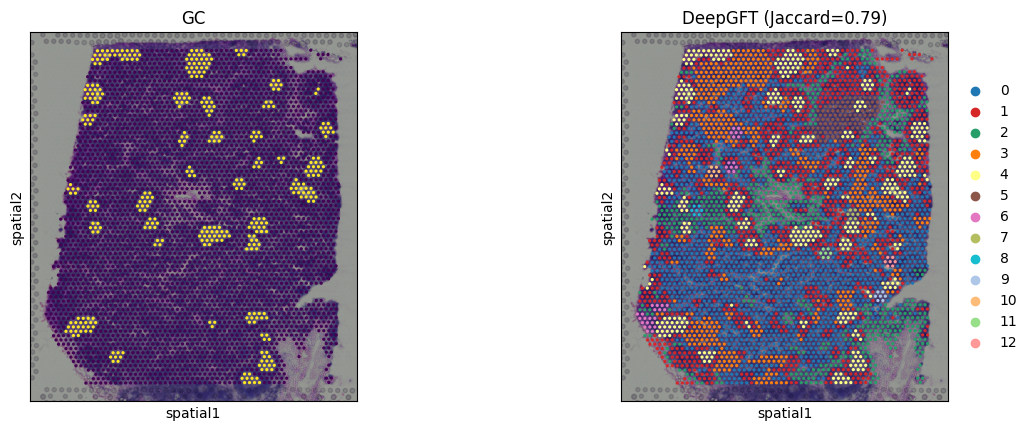

In [8]:
adata.uns['leiden_colors'] = ['#1f77b4', '#d62728', '#279e68', '#ff7f0e', '#ffff85', '#8c564b', '#e377c2', 
                               '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']
sc.pl.spatial(adata, color=["cell_type", "leiden"], title=['GC', 'DeepGFT (Jaccard=%.2f)' % jac_max], colorbar_loc=None)

### Gene denoise

In [9]:
res_denoising, att = denoising(res, adata.uns['spotnet_adj'], attention[:, 0])
adata_res = adata.copy()
adata_res.X = res_denoising

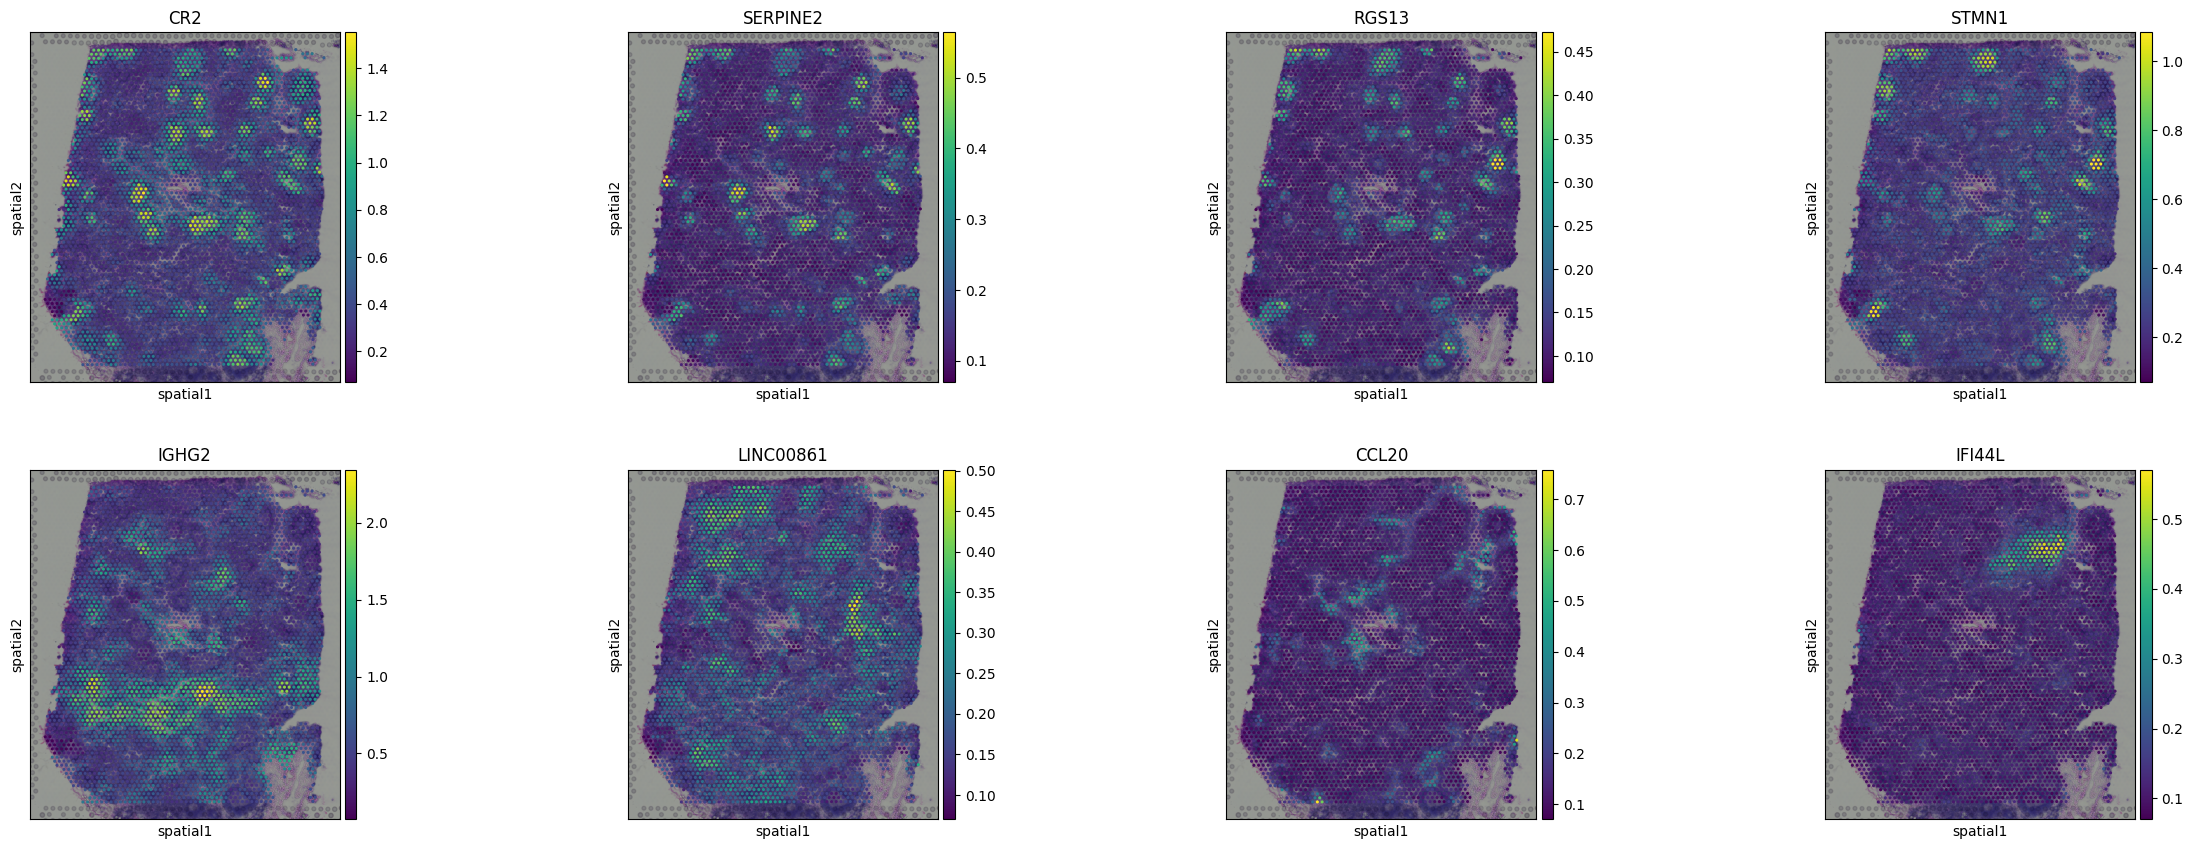

In [10]:
svg_list = ['CR2', 'SERPINE2', 'RGS13', 'STMN1', 'IGHG2', 'LINC00861', 'CCL20', 'IFI44L']
sc.pl.spatial(adata_res, color=svg_list)